# Лабораторная работа №7
## Выполнил: Пелагеев Даниил Иванович Б9122-01.03.02мкт

В этой лабораторной работе мы будем применять методы множественной линейной регрессии к датасету **seeds_dataset.txt**. Цель состоит в том, чтобы предсказать площадь зерна (**Area**) на основе остальных параметров. Мы также визуализируем результаты с помощью графиков линейной регрессии и обсудим дополнительные аспекты модели.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
data = 'datasets/seeds_dataset.txt'
columns = ['Area', 'Perimeter', 'Compactness', 'Length of kernel', 'Width of kernel',
           'Asymmetry coefficient', 'Length of kernel groove', 'Class']

df = pd.read_csv(data, sep='\t', names=columns)
print('Размерность датасета:', df.shape, end='\n\n')
df.head(10)

Размерность датасета: (210, 8)



,Area,Perimeter,Compactness,Length of kernel,Width of kernel,Asymmetry coefficient,Length of kernel groove,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1
7,14.11,14.10,0.8911,5.420,3.302,2.700,5.000,1
8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1


In [3]:
df.info()
df = df.dropna()  # Чистим наш датасет от na
print('Размерность датасета после чистки:', df.shape, end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of kernel         210 non-null    float64
 4   Width of kernel          210 non-null    float64
 5   Asymmetry coefficient    210 non-null    float64
 6   Length of kernel groove  210 non-null    float64
 7   Class                    210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB
Размерность датасета после чистки: (210, 8)



Результатом этого блока кода является очистка датасета, но как видим размерность до чистки и после никак не изменилась

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

print("Матрица признаков:")
print(X[:5])
print("\nЗависимая переменная:")
print(y[:5])

Матрица признаков:
[[14.84    0.871   5.763   3.312   2.221   5.22    1.    ]
 [14.57    0.8811  5.554   3.333   1.018   4.956   1.    ]
 [14.09    0.905   5.291   3.337   2.699   4.825   1.    ]
 [13.94    0.8955  5.324   3.379   2.259   4.805   1.    ]
 [14.99    0.9034  5.658   3.562   1.355   5.175   1.    ]]

Зависимая переменная:
[15.26 14.88 14.29 13.84 16.14]


В этом блоке мы разделяем данные на **матрицу признаков** и **зависимую переменную**:
1. **Матрица признаков (`X`)**:
   - Используется `df.iloc[:, 1:].values` для выбора всех столбцов, кроме первого (`'Area'`).
2. **Зависимая переменная (`y`)**:
   - Используется `df.iloc[:, 0].values` для выбора первого столбца (`'Area'`).

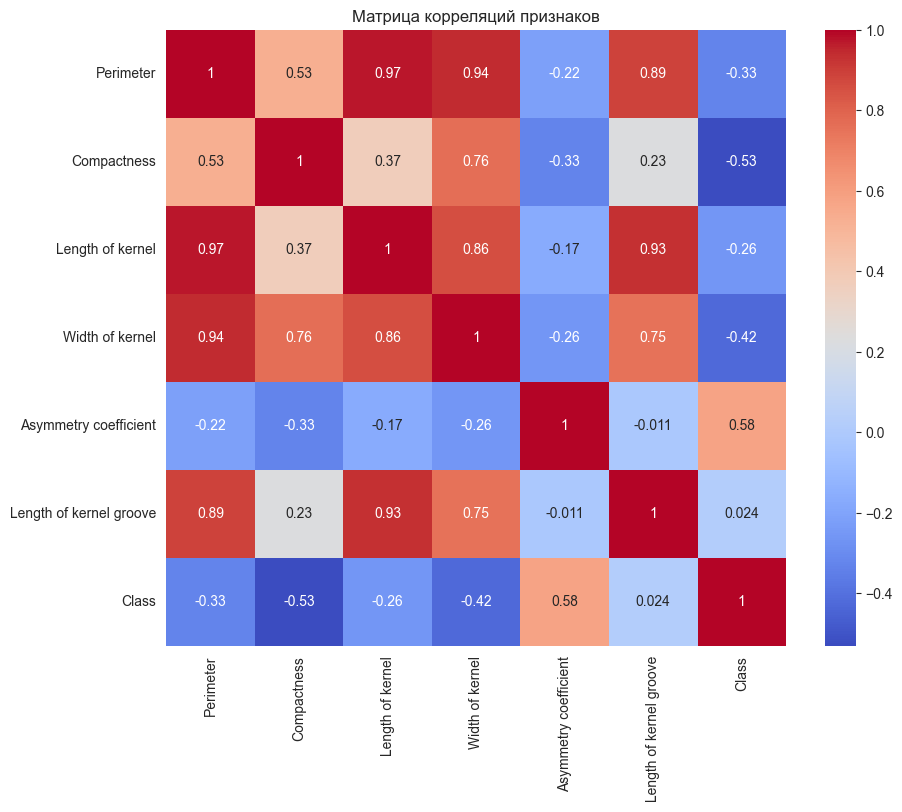

In [5]:
# Построение корреляционной матрицы
corr_matrix = df.drop('Area', axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций признаков')
plt.show()

Этот анализ помогает выявить признаки, которые могут быть избыточными или сильно взаимосвязаны, что важно для оптимизации модели.

**Анализ**:
- **Высокие корреляции** между признаками могут привести к мультиколлинеарности, что ухудшает стабильность и интерпретируемость модели.
- **Низкие корреляции** указывают на независимость признаков, что предпочтительно для моделей линейной регрессии.


In [6]:
labelencoder_X = LabelEncoder()
X[:, -1] = labelencoder_X.fit_transform(X[:, -1])

# Применение OneHotEncoder
ct = ColumnTransformer([("Class", OneHotEncoder(), [-1])], remainder='passthrough')
X = ct.fit_transform(X)

# Избегаем ловушки фиктивных переменных
X = X[:, 1:]

print("Матрица признаков после кодирования категориального признака 'Class':")
print(X[:5])


Матрица признаков после кодирования категориального признака 'Class':
[[ 0.      0.     14.84    0.871   5.763   3.312   2.221   5.22  ]
 [ 0.      0.     14.57    0.8811  5.554   3.333   1.018   4.956 ]
 [ 0.      0.     14.09    0.905   5.291   3.337   2.699   4.825 ]
 [ 0.      0.     13.94    0.8955  5.324   3.379   2.259   4.805 ]
 [ 0.      0.     14.99    0.9034  5.658   3.562   1.355   5.175 ]]


Этот блок выполняет кодирование категориального признака **'Class'** для преобразования его в числовой формат, так как столбец **'Class'** является категориальным признаком, необходимо преобразовать его в числовой формат, что необходимо для обучения модели машинного обучения.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (168, 8)
Размер тестовой выборки: (42, 8)


В этом блоке выполняем разделение данных на **тренировочную** и **тестовую** выборки

In [8]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

regressor

LinearRegression()

In [9]:
scores = cross_val_score(regressor, X, y, scoring='r2', cv=10)
print("Среднее значение R² при кросс-валидации:", scores.mean())

Среднее значение R² при кросс-валидации: 0.9845058646507846


In [10]:
y_pred = regressor.predict(X_test)

# Сравнение предсказанных и реальных значений
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_pred.head())


   Actual  Predicted
0   13.89  13.854948
1   16.53  16.675523
2   13.94  13.942327
3   14.38  14.396824
4   11.23  11.129017


В этом блоке выполняем предсказание и сравнение результатов модели:

1. **Предсказание**:
   - Метод `predict` используется для предсказания значений зависимой переменной на основе тестовых данных `X_test`.
   - Результат сохраняется в переменную `y_pred`.

2. **Сравнение предсказанных и реальных значений**:
   - Создается DataFrame `df_pred`, содержащий две колонки: реальные значения `Actual` из `y_test` и предсказанные значения `Predicted` из `y_pred`.
   - `df_pred.head()` отображает первые 5 строк для предварительного анализа.

Этот шаг позволяет оценить, насколько хорошо модель способна предсказывать новые данные, сравнивая её предсказания с реальными значениями.

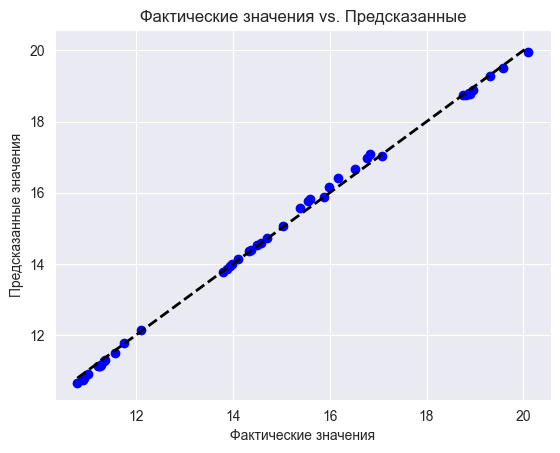

In [11]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические значения vs. Предсказанные')
plt.show()

Этот график позволяет визуально оценить качество предсказаний модели:

- **Точки на графике**: Каждая точка представляет собой пару `(Actual, Predicted)`.
- **Черная пунктирная линия (`y = x`)**: Отображает идеальное соответствие между фактическими и предсказанными значениями.
- **Анализ**:
  - **Точки, близкие к линии**: Указывают на точные предсказания модели.
  - **Рассеяние точек вокруг линии**: Показывает отклонения предсказаний от реальных значений.

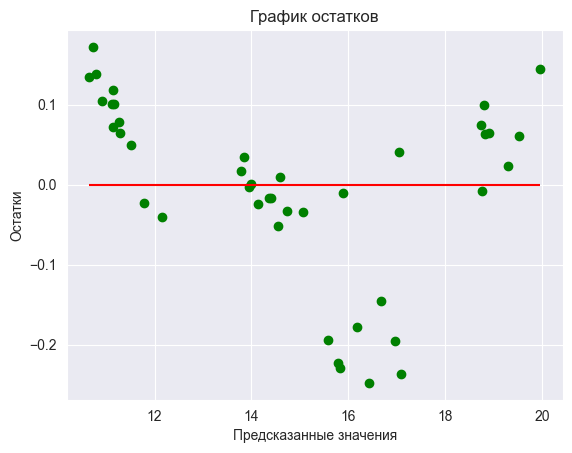

In [12]:
residuals = y_test - y_pred

# Построение графика остатков
plt.scatter(y_pred, residuals, color='green')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

Этот график помогает выявить потенциальные проблемы в модели и определить необходимость её улучшения.

**Остатки (`residuals`)**: Разница между фактическими и предсказанными значениями (`y_test - y_pred`).


**Точки на графике**: Отображают зависимость остатков от предсказанных значений.
**Красная горизонтальная линия (`y = 0`)**: Показывает, где остатки равны нулю.

**Анализ**:
- **Равномерное распределение**: Если остатки равномерно распределены вокруг нуля без явных паттернов, это свидетельствует о корректности модели.
- **Паттерны в остатках**: Могут указывать на наличие нелинейных зависимостей, гетероскедастичности или других нарушений предположений модели.


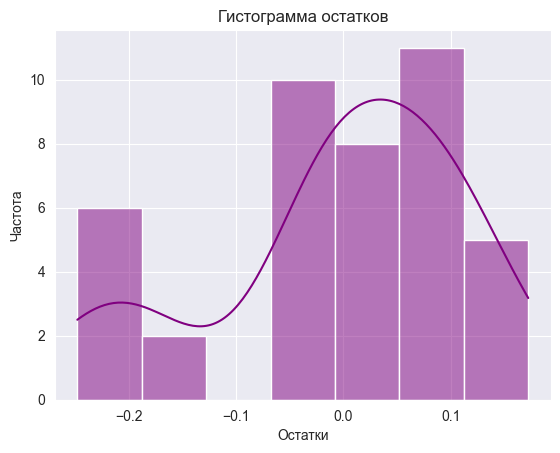

In [13]:
# Построение гистограммы остатков
sns.histplot(residuals, kde=True, color='purple')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

Этот график помогает оценить соответствие остатков предположению о нормальности, что важно для статистической интерпретации модели.

**Гистограмма**: Отображает частоту возникновения различных значений остатков.

**Линия плотности (`kde=True`)**: Показывает оценку плотности распределения остатков.

**Анализ**:
- **Нормальное распределение**: Если гистограмма и линия плотности напоминают нормальное распределение, это подтверждает корректность предположений модели.
- **Отклонения от нормальности**: Могут указывать на необходимость использования других моделей или трансформаций данных.

In [14]:
# Добавление столбца единиц для константы
X_opt = np.append(arr=np.ones((X.shape[0], 1)).astype(int), values=X, axis=1)

# Инициализация списка признаков для оптимизации
X_opt = X_opt[:, range(X_opt.shape[1])]

# Установка уровня значимости
SL = 0.05

# Функция для выполнения обратного исключения
def backward_elimination(x, y, SL):
    numVars = x.shape[1]
    for i in range(numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxPVal = max(regressor_OLS.pvalues).astype(float)
        if maxPVal > SL:
            idx = np.argmax(regressor_OLS.pvalues)
            print(f"Исключение признака с индексом {idx}, P-значение: {maxPVal}")
            x = np.delete(x, idx, 1)
        else:
            break
    return x

X_Modeled = backward_elimination(X_opt, y, SL)

Исключение признака с индексом 8, P-значение: 0.5257786991231245
Исключение признака с индексом 7, P-значение: 0.3087211957837556
Исключение признака с индексом 5, P-значение: 0.1304364183902391


Этот блок выполняет **метод обратного исключения (Backward Elimination)** для отбора значимых признаков:

1. **Добавление константы**:
   - `np.ones` добавляет столбец единиц для включения константы (свободного члена) в модель.

2. **Инициализация**:
   - `X_opt` изначально содержит все признаки, включая константу.

3. **Установка уровня значимости (`SL`)**:
   - Определяет порог для исключения признаков. Признаки с `p-значением` выше этого порога будут удалены.

4. **Функция `backward_elimination`**:
   - Последовательно удаляет признаки с наибольшим `p-значением`, превышающим `SL`.
   - На каждом шаге строится модель OLS (Ordinary Least Squares) и оцениваются `p-значения` признаков.
   - Признак с наивысшим `p-значением` удаляется, если оно превышает `SL`.
   - Процесс повторяется до тех пор, пока все признаки имеют `p-значения` ниже порога.

5. **Результат**:
   - `X_Modeled` содержит только значимые признаки после оптимизации.

Этот шаг необходим для упрощения модели, улучшения её интерпретируемости и предотвращения переобучения за счет удаления незначимых или избыточных признаков.

In [15]:
regressor_OLS = sm.OLS(endog=y, exog=X_Modeled).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.260e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):          6.03e-294
Time:                        20:58:56   Log-Likelihood:                 180.12
No. Observations:                 210   AIC:                            -348.2
Df Residuals:                     204   BIC:                            -328.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.9427      0.979    -26.492      0.0

Этот блок кода позволяет оценить качество модели после отбора признаков и понять, какие переменные существенно влияют на зависимую переменную.

- **R-квадрат (0.999)**: Указывает, что модель объясняет 99.9% вариации зависимой переменной, что свидетельствует о высокой подгонке.
- **P-значения**:
  - Переменные `x1`, `x2`, `x3`, и `x4` имеют `p-значения` ниже 0.01, что указывает на их статистическую значимость.
- **Предупреждения о мультиколлинеарности**: Низкое значение `Cond. No.` указывает на отсутствие проблем с мультиколлинеарностью между признаками.